In [26]:
import os
import json
import pandas as pd
from torch.utils.data import DataLoader
from PIL import Image, ImageFile
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor as tt
from torchvision.utils import make_grid
from tqdm import tqdm
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [27]:
!pip install torchsummary

In [28]:
BATCH_SIZE = 128
NUM_EPOCHS = 20
LEARNING_RATE = 0.0001
ROOT_DIR = "/kaggle/input/bonemarrowdatasetprocessed-for-classification-task/data_processed/"

In [29]:
train_df = pd.read_csv(f"{ROOT_DIR}data/train.csv")
val_df = pd.read_csv(f"{ROOT_DIR}data/val.csv")
test_df = pd.read_csv(f"{ROOT_DIR}data/test.csv")

train_df.shape, val_df.shape, test_df.shape

((119961, 3), (16967, 3), (34446, 3))

In [30]:
class BMDataset():
    
    def __init__(self, dataframe, shape=(224, 224), system = "windows"):
        self.dataframe = dataframe
        self.shape = shape
        if system == "linux":
            self.dataframe["path"] = self.dataframe["path"].apply(self.process_path_on_linux)
    
    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        path = os.path.join(ROOT_DIR, self.dataframe.iloc[idx, 0])
        label = self.dataframe.iloc[idx, 2]
        img = self._load_img(path)

        return img, label
    
    def process_path_on_linux(self, path):
        return "/".join(path.split("\\"))

    def _load_img(self, path):
        img = Image.open(path)
        img = img.resize(self.shape)
        img = tt()(img)
        return img


train_ds = BMDataset(train_df, system="linux")
val_ds = BMDataset(val_df,system="linux")
test_ds = BMDataset(test_df, system="linux")

In [31]:
train_dl = DataLoader(train_ds, batch_size = BATCH_SIZE, shuffle=True, drop_last = False)
val_dl = DataLoader(val_ds, batch_size = BATCH_SIZE, shuffle=True, drop_last = False)
test_dl = DataLoader(test_ds, batch_size = BATCH_SIZE, shuffle=True, drop_last = False)

In [32]:
rand_train_batch_image, rand_train_batch_labels = next(iter(train_dl))
rand_train_batch_image.shape, rand_train_batch_labels.shape

(torch.Size([128, 3, 224, 224]), torch.Size([128]))

In [33]:
import torch
import torch.nn as nn
from torchvision import models
from torchvision.transforms import Resize

In [34]:
class BMBaseModel(nn.Module):

    def __init__(self, network, num_classes):
        super(BMBaseModel, self).__init__()
        if network == "resnet":
            self.featurizer = torch.hub.load('pytorch/vision:v0.10.0', "resnet18", pretrained=True)
        elif network == "inception":
            self.featurizer = torch.hub.load('pytorch/vision:v0.10.0', 'inception', pretrained=True)
        elif network == "googlenet":
            self.featurizer = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)
        #self.featurizer = self._freeze_layers(self.featurizer)
        self.mid_blocks = nn.Sequential(
                nn.Linear(1000, 2048),
                nn.ReLU(),
                nn.Linear(2048, 1024),
                nn.ReLU(),
                nn.Linear(1024, 256),
        )
        self.output_layer = nn.Linear(256, num_classes)

    def _freeze_layers(self, network):
        for param in network.parameters():
            param.requires_grad = False
        return network
    
    def forward(self, x):
        featurizer_op = self.featurizer(x)
        flattened_op = featurizer_op.view(featurizer_op.shape[0], -1)
        return self.output_layer(self.mid_blocks(flattened_op))

In [35]:
from torchsummary import summary

model = BMBaseModel("googlenet", 21)

summary(model, (3, 224, 224), batch_size=BATCH_SIZE, device="cpu")

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [128, 64, 112, 112]           9,408
       BatchNorm2d-2        [128, 64, 112, 112]             128
       BasicConv2d-3        [128, 64, 112, 112]               0
         MaxPool2d-4          [128, 64, 56, 56]               0
            Conv2d-5          [128, 64, 56, 56]           4,096
       BatchNorm2d-6          [128, 64, 56, 56]             128
       BasicConv2d-7          [128, 64, 56, 56]               0
            Conv2d-8         [128, 192, 56, 56]         110,592
       BatchNorm2d-9         [128, 192, 56, 56]             384
      BasicConv2d-10         [128, 192, 56, 56]               0
        MaxPool2d-11         [128, 192, 28, 28]               0
           Conv2d-12          [128, 64, 28, 28]          12,288
      BatchNorm2d-13          [128, 64, 28, 28]             128
      BasicConv2d-14          [128, 64,

In [36]:
chkp = torch.load(f"/kaggle/input/bonemarrowdatasetprocessed-for-classification-task/exp4_best.pt")
model.load_state_dict(chkp["model"])

<All keys matched successfully>

In [37]:
model.eval()
model = model.cuda()

In [38]:
def predict(model, dl):
    true = []
    pred = []
    for batch, labels in tqdm(dl):
        op = model(batch.cuda())
        true += labels.detach().numpy().tolist()
        pred += torch.argmax(op, dim=1).cpu().detach().numpy().tolist()
        del op, batch
    return true, pred

In [39]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import classification_report

In [40]:
cols = ["ABE", "ART","BAS", "BLA", "EBO", "EOS", "FGC", "HAC", "KSC", "LYI", "LYT", "MMZ", "MON", "MYB", "NGB", "NGS", "NIF", "OTH", "PEB", "PLM", "PMO"]

100%|██████████| 938/938 [10:33<00:00,  1.48it/s]


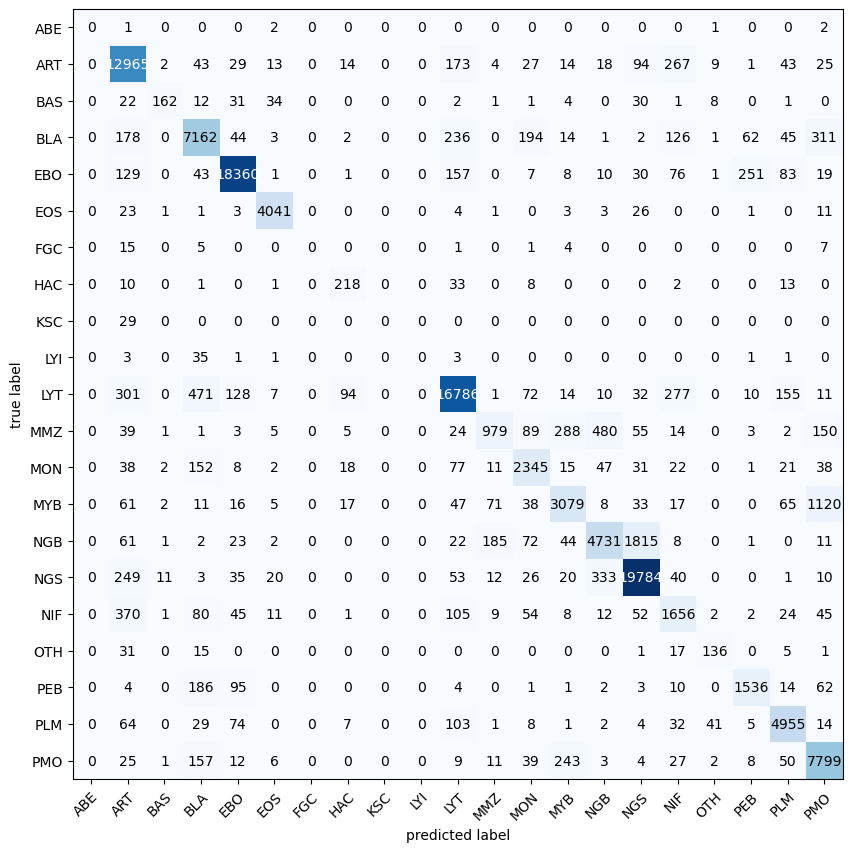

In [41]:
train_true, train_pred = predict(model, train_dl)
plot_confusion_matrix(confusion_matrix(train_true, train_pred), figsize=(10, 10), class_names=cols)
plt.savefig("train_conf_mat.png")

100%|██████████| 133/133 [01:18<00:00,  1.69it/s]


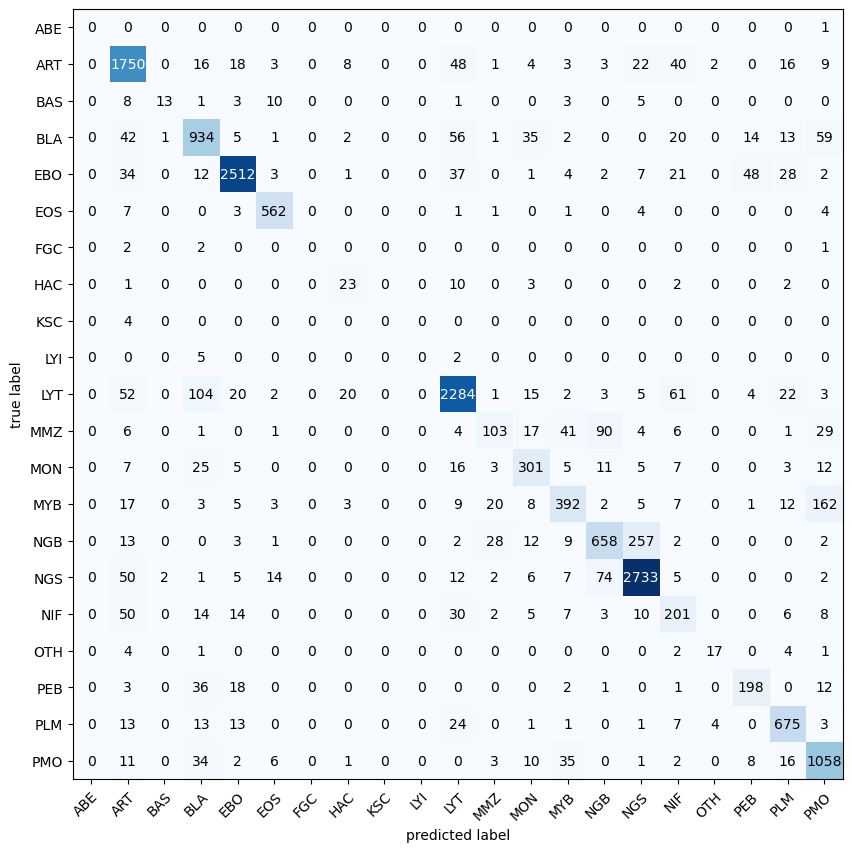

In [42]:
val_true, val_pred = predict(model, val_dl)
plot_confusion_matrix(confusion_matrix(val_true, val_pred), figsize=(10, 10), class_names=cols)
plt.savefig("val_conf_mat.png")

100%|██████████| 270/270 [02:33<00:00,  1.76it/s]


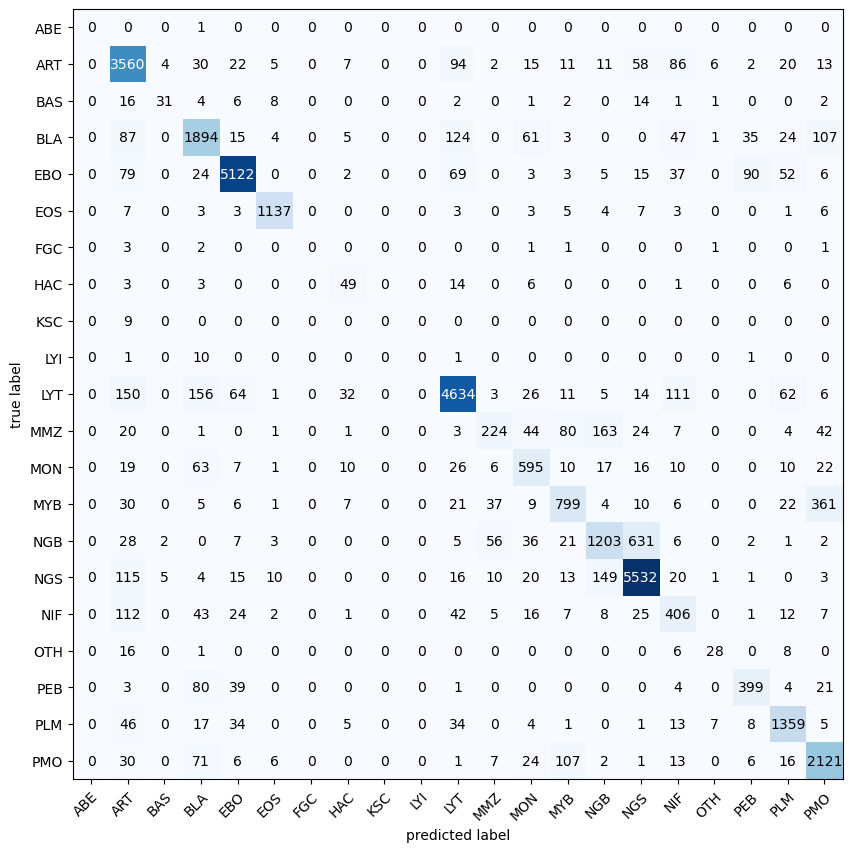

In [43]:
test_true, test_pred = predict(model, test_dl)
plot_confusion_matrix(confusion_matrix(test_true, test_pred), figsize=(10, 10), class_names=cols)
plt.savefig("test_conf_mat.png")

In [44]:
classification_report(train_true, train_pred)

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


'              precision    recall  f1-score   support\n\n           0       0.00      0.00      0.00         6\n           1       0.89      0.94      0.91     13741\n           2       0.88      0.52      0.66       309\n           3       0.85      0.85      0.85      8381\n           4       0.97      0.96      0.96     19176\n           5       0.97      0.98      0.98      4118\n           6       0.00      0.00      0.00        33\n           7       0.58      0.76      0.66       286\n           8       0.00      0.00      0.00        29\n           9       0.00      0.00      0.00        45\n          10       0.94      0.91      0.93     18369\n          11       0.76      0.46      0.57      2138\n          12       0.79      0.83      0.81      2828\n          13       0.82      0.67      0.74      4590\n          14       0.84      0.68      0.75      6978\n          15       0.90      0.96      0.93     20597\n          16       0.64      0.67      0.65      2477\n       

In [45]:
classification_report(val_true, val_pred)

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


'              precision    recall  f1-score   support\n\n           0       0.00      0.00      0.00         1\n           1       0.84      0.90      0.87      1943\n           2       0.81      0.30      0.43        44\n           3       0.78      0.79      0.78      1185\n           4       0.96      0.93      0.94      2712\n           5       0.93      0.96      0.95       583\n           6       0.00      0.00      0.00         5\n           7       0.40      0.56      0.46        41\n           8       0.00      0.00      0.00         4\n           9       0.00      0.00      0.00         7\n          10       0.90      0.88      0.89      2598\n          11       0.62      0.34      0.44       303\n          12       0.72      0.75      0.74       400\n          13       0.76      0.60      0.67       649\n          14       0.78      0.67      0.72       987\n          15       0.89      0.94      0.92      2913\n          16       0.52      0.57      0.55       350\n       

In [46]:
classification_report(test_true, test_pred)

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


'              precision    recall  f1-score   support\n\n           0       0.00      0.00      0.00         1\n           1       0.82      0.90      0.86      3946\n           2       0.74      0.35      0.48        88\n           3       0.79      0.79      0.79      2407\n           4       0.95      0.93      0.94      5507\n           5       0.96      0.96      0.96      1182\n           6       0.00      0.00      0.00         9\n           7       0.41      0.60      0.49        82\n           8       0.00      0.00      0.00         9\n           9       0.00      0.00      0.00        13\n          10       0.91      0.88      0.89      5275\n          11       0.64      0.36      0.46       614\n          12       0.69      0.73      0.71       812\n          13       0.74      0.61      0.67      1318\n          14       0.77      0.60      0.67      2003\n          15       0.87      0.94      0.90      5914\n          16       0.52      0.57      0.55       711\n       

               precision    recall  f1-score   support
0                   0.00      0.00      0.00         6
1                   0.89      0.94      0.91     13741
2                   0.88      0.52      0.66       309
3                   0.85      0.85      0.85      8381
4                   0.97      0.96      0.96     19176
5                   0.97      0.98      0.98      4118
6                   0.00      0.00      0.00        33
7                   0.58      0.76      0.66       286
8                   0.00      0.00      0.00        29
9                   0.00      0.00      0.00        45
10                  0.94      0.91      0.93     18369
11                  0.76      0.46      0.57      2138
12                  0.79      0.83      0.81      2828
13                  0.82      0.67      0.74      4590
14                  0.84      0.68      0.75      6978
15                  0.90      0.96      0.93     20597
16                  0.64      0.67      0.65      2477
17                  0.68      0.66      0.67       206
18                  0.82      0.80      0.81      1918
19                  0.90      0.93      0.92      5340
20                  0.81      0.93      0.87      8396
accuracy                                0.89    119961
macro avg           0.67      0.64      0.65    119961
weighted avg        0.89      0.89      0.89    119961

               precision    recall  f1-score   support
0                   0.00      0.00      0.00         1
1                   0.84      0.90      0.87      1943
2                   0.81      0.30      0.43        44
3                   0.78      0.79      0.78      1185
4                   0.96      0.93      0.94      2712
5                   0.93      0.96      0.95       583
6                   0.00      0.00      0.00         5
7                   0.40      0.56      0.46        41
8                   0.00      0.00      0.00         4
9                   0.00      0.00      0.00         7
10                  0.90      0.88      0.89      2598
11                  0.62      0.34      0.44       303
12                  0.72      0.75      0.74       400
13                  0.76      0.60      0.67       649
14                  0.78      0.67      0.72       987
15                  0.89      0.94      0.92      2913
16                  0.52      0.57      0.55       350
17                  0.74      0.59      0.65        29
18                  0.73      0.73      0.73       271
19                  0.85      0.89      0.87       755
20                  0.77      0.89      0.83      1187
accuracy                                0.85     16967
macro avg           0.62      0.59      0.59     16967
weighted avg        0.85      0.85      0.85     16967

               precision    recall  f1-score   support
0                   0.00      0.00      0.00         1
1                   0.82      0.90      0.86      3946
2                   0.74      0.35      0.48        88
3                   0.79      0.79      0.79      2407
4                   0.95      0.93      0.94      5507
5                   0.96      0.96      0.96      1182
6                   0.00      0.00      0.00         9
7                   0.41      0.60      0.49        82
8                   0.00      0.00      0.00         9
9                   0.00      0.00      0.00        13
10                  0.91      0.88      0.89      5275
11                  0.64      0.36      0.46       614
12                  0.69      0.73      0.71       812
13                  0.74      0.61      0.67      1318
14                  0.77      0.60      0.67      2003
15                  0.87      0.94      0.90      5914
16                  0.52      0.57      0.55       711
17                  0.62      0.47      0.54        59
18                  0.73      0.72      0.73       551
19                  0.85      0.89      0.87      1534
20                  0.78      0.88      0.83      2411
accuracy                                0.84     34446
macro avg           0.61      0.58      0.59     34446
weighted avg        0.84      0.84      0.84     34446

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
================================================================
            Conv2d-1        [128, 64, 112, 112]           9,408
       BatchNorm2d-2        [128, 64, 112, 112]             128
       BasicConv2d-3        [128, 64, 112, 112]               0
         MaxPool2d-4          [128, 64, 56, 56]               0
            Conv2d-5          [128, 64, 56, 56]           4,096
       BatchNorm2d-6          [128, 64, 56, 56]             128
       BasicConv2d-7          [128, 64, 56, 56]               0
            Conv2d-8         [128, 192, 56, 56]         110,592
       BatchNorm2d-9         [128, 192, 56, 56]             384
      BasicConv2d-10         [128, 192, 56, 56]               0
        MaxPool2d-11         [128, 192, 28, 28]               0
           Conv2d-12          [128, 64, 28, 28]          12,288
      BatchNorm2d-13          [128, 64, 28, 28]             128
      BasicConv2d-14          [128, 64, 28, 28]               0
           Conv2d-15          [128, 96, 28, 28]          18,432
      BatchNorm2d-16          [128, 96, 28, 28]             192
      BasicConv2d-17          [128, 96, 28, 28]               0
           Conv2d-18         [128, 128, 28, 28]         110,592
      BatchNorm2d-19         [128, 128, 28, 28]             256
      BasicConv2d-20         [128, 128, 28, 28]               0
           Conv2d-21          [128, 16, 28, 28]           3,072
      BatchNorm2d-22          [128, 16, 28, 28]              32
      BasicConv2d-23          [128, 16, 28, 28]               0
           Conv2d-24          [128, 32, 28, 28]           4,608
      BatchNorm2d-25          [128, 32, 28, 28]              64
      BasicConv2d-26          [128, 32, 28, 28]               0
        MaxPool2d-27         [128, 192, 28, 28]               0
           Conv2d-28          [128, 32, 28, 28]           6,144
      BatchNorm2d-29          [128, 32, 28, 28]              64
      BasicConv2d-30          [128, 32, 28, 28]               0
        Inception-31         [128, 256, 28, 28]               0
           Conv2d-32         [128, 128, 28, 28]          32,768
      BatchNorm2d-33         [128, 128, 28, 28]             256
      BasicConv2d-34         [128, 128, 28, 28]               0
           Conv2d-35         [128, 128, 28, 28]          32,768
      BatchNorm2d-36         [128, 128, 28, 28]             256
      BasicConv2d-37         [128, 128, 28, 28]               0
           Conv2d-38         [128, 192, 28, 28]         221,184
      BatchNorm2d-39         [128, 192, 28, 28]             384
      BasicConv2d-40         [128, 192, 28, 28]               0
           Conv2d-41          [128, 32, 28, 28]           8,192
      BatchNorm2d-42          [128, 32, 28, 28]              64
      BasicConv2d-43          [128, 32, 28, 28]               0
           Conv2d-44          [128, 96, 28, 28]          27,648
      BatchNorm2d-45          [128, 96, 28, 28]             192
      BasicConv2d-46          [128, 96, 28, 28]               0
        MaxPool2d-47         [128, 256, 28, 28]               0
           Conv2d-48          [128, 64, 28, 28]          16,384
      BatchNorm2d-49          [128, 64, 28, 28]             128
      BasicConv2d-50          [128, 64, 28, 28]               0
        Inception-51         [128, 480, 28, 28]               0
        MaxPool2d-52         [128, 480, 14, 14]               0
           Conv2d-53         [128, 192, 14, 14]          92,160
      BatchNorm2d-54         [128, 192, 14, 14]             384
      BasicConv2d-55         [128, 192, 14, 14]               0
           Conv2d-56          [128, 96, 14, 14]          46,080
      BatchNorm2d-57          [128, 96, 14, 14]             192
      BasicConv2d-58          [128, 96, 14, 14]               0
           Conv2d-59         [128, 208, 14, 14]         179,712
      BatchNorm2d-60         [128, 208, 14, 14]             416
      BasicConv2d-61         [128, 208, 14, 14]               0
           Conv2d-62          [128, 16, 14, 14]           7,680
      BatchNorm2d-63          [128, 16, 14, 14]              32
      BasicConv2d-64          [128, 16, 14, 14]               0
           Conv2d-65          [128, 48, 14, 14]           6,912
      BatchNorm2d-66          [128, 48, 14, 14]              96
      BasicConv2d-67          [128, 48, 14, 14]               0
        MaxPool2d-68         [128, 480, 14, 14]               0
           Conv2d-69          [128, 64, 14, 14]          30,720
      BatchNorm2d-70          [128, 64, 14, 14]             128
      BasicConv2d-71          [128, 64, 14, 14]               0
        Inception-72         [128, 512, 14, 14]               0
           Conv2d-73         [128, 160, 14, 14]          81,920
      BatchNorm2d-74         [128, 160, 14, 14]             320
      BasicConv2d-75         [128, 160, 14, 14]               0
           Conv2d-76         [128, 112, 14, 14]          57,344
      BatchNorm2d-77         [128, 112, 14, 14]             224
      BasicConv2d-78         [128, 112, 14, 14]               0
           Conv2d-79         [128, 224, 14, 14]         225,792
      BatchNorm2d-80         [128, 224, 14, 14]             448
      BasicConv2d-81         [128, 224, 14, 14]               0
           Conv2d-82          [128, 24, 14, 14]          12,288
      BatchNorm2d-83          [128, 24, 14, 14]              48
      BasicConv2d-84          [128, 24, 14, 14]               0
           Conv2d-85          [128, 64, 14, 14]          13,824
      BatchNorm2d-86          [128, 64, 14, 14]             128
      BasicConv2d-87          [128, 64, 14, 14]               0
        MaxPool2d-88         [128, 512, 14, 14]               0
           Conv2d-89          [128, 64, 14, 14]          32,768
      BatchNorm2d-90          [128, 64, 14, 14]             128
      BasicConv2d-91          [128, 64, 14, 14]               0
        Inception-92         [128, 512, 14, 14]               0
           Conv2d-93         [128, 128, 14, 14]          65,536
      BatchNorm2d-94         [128, 128, 14, 14]             256
      BasicConv2d-95         [128, 128, 14, 14]               0
           Conv2d-96         [128, 128, 14, 14]          65,536
      BatchNorm2d-97         [128, 128, 14, 14]             256
      BasicConv2d-98         [128, 128, 14, 14]               0
           Conv2d-99         [128, 256, 14, 14]         294,912
     BatchNorm2d-100         [128, 256, 14, 14]             512
     BasicConv2d-101         [128, 256, 14, 14]               0
          Conv2d-102          [128, 24, 14, 14]          12,288
     BatchNorm2d-103          [128, 24, 14, 14]              48
     BasicConv2d-104          [128, 24, 14, 14]               0
          Conv2d-105          [128, 64, 14, 14]          13,824
     BatchNorm2d-106          [128, 64, 14, 14]             128
     BasicConv2d-107          [128, 64, 14, 14]               0
       MaxPool2d-108         [128, 512, 14, 14]               0
          Conv2d-109          [128, 64, 14, 14]          32,768
     BatchNorm2d-110          [128, 64, 14, 14]             128
     BasicConv2d-111          [128, 64, 14, 14]               0
       Inception-112         [128, 512, 14, 14]               0
          Conv2d-113         [128, 112, 14, 14]          57,344
     BatchNorm2d-114         [128, 112, 14, 14]             224
     BasicConv2d-115         [128, 112, 14, 14]               0
          Conv2d-116         [128, 144, 14, 14]          73,728
     BatchNorm2d-117         [128, 144, 14, 14]             288
     BasicConv2d-118         [128, 144, 14, 14]               0
          Conv2d-119         [128, 288, 14, 14]         373,248
     BatchNorm2d-120         [128, 288, 14, 14]             576
     BasicConv2d-121         [128, 288, 14, 14]               0
          Conv2d-122          [128, 32, 14, 14]          16,384
     BatchNorm2d-123          [128, 32, 14, 14]              64
     BasicConv2d-124          [128, 32, 14, 14]               0
          Conv2d-125          [128, 64, 14, 14]          18,432
     BatchNorm2d-126          [128, 64, 14, 14]             128
     BasicConv2d-127          [128, 64, 14, 14]               0
       MaxPool2d-128         [128, 512, 14, 14]               0
          Conv2d-129          [128, 64, 14, 14]          32,768
     BatchNorm2d-130          [128, 64, 14, 14]             128
     BasicConv2d-131          [128, 64, 14, 14]               0
       Inception-132         [128, 528, 14, 14]               0
          Conv2d-133         [128, 256, 14, 14]         135,168
     BatchNorm2d-134         [128, 256, 14, 14]             512
     BasicConv2d-135         [128, 256, 14, 14]               0
          Conv2d-136         [128, 160, 14, 14]          84,480
     BatchNorm2d-137         [128, 160, 14, 14]             320
     BasicConv2d-138         [128, 160, 14, 14]               0
          Conv2d-139         [128, 320, 14, 14]         460,800
     BatchNorm2d-140         [128, 320, 14, 14]             640
     BasicConv2d-141         [128, 320, 14, 14]               0
          Conv2d-142          [128, 32, 14, 14]          16,896
     BatchNorm2d-143          [128, 32, 14, 14]              64
     BasicConv2d-144          [128, 32, 14, 14]               0
          Conv2d-145         [128, 128, 14, 14]          36,864
     BatchNorm2d-146         [128, 128, 14, 14]             256
     BasicConv2d-147         [128, 128, 14, 14]               0
       MaxPool2d-148         [128, 528, 14, 14]               0
          Conv2d-149         [128, 128, 14, 14]          67,584
     BatchNorm2d-150         [128, 128, 14, 14]             256
     BasicConv2d-151         [128, 128, 14, 14]               0
       Inception-152         [128, 832, 14, 14]               0
       MaxPool2d-153           [128, 832, 7, 7]               0
          Conv2d-154           [128, 256, 7, 7]         212,992
     BatchNorm2d-155           [128, 256, 7, 7]             512
     BasicConv2d-156           [128, 256, 7, 7]               0
          Conv2d-157           [128, 160, 7, 7]         133,120
     BatchNorm2d-158           [128, 160, 7, 7]             320
     BasicConv2d-159           [128, 160, 7, 7]               0
          Conv2d-160           [128, 320, 7, 7]         460,800
     BatchNorm2d-161           [128, 320, 7, 7]             640
     BasicConv2d-162           [128, 320, 7, 7]               0
          Conv2d-163            [128, 32, 7, 7]          26,624
     BatchNorm2d-164            [128, 32, 7, 7]              64
     BasicConv2d-165            [128, 32, 7, 7]               0
          Conv2d-166           [128, 128, 7, 7]          36,864
     BatchNorm2d-167           [128, 128, 7, 7]             256
     BasicConv2d-168           [128, 128, 7, 7]               0
       MaxPool2d-169           [128, 832, 7, 7]               0
          Conv2d-170           [128, 128, 7, 7]         106,496
     BatchNorm2d-171           [128, 128, 7, 7]             256
     BasicConv2d-172           [128, 128, 7, 7]               0
       Inception-173           [128, 832, 7, 7]               0
          Conv2d-174           [128, 384, 7, 7]         319,488
     BatchNorm2d-175           [128, 384, 7, 7]             768
     BasicConv2d-176           [128, 384, 7, 7]               0
          Conv2d-177           [128, 192, 7, 7]         159,744
     BatchNorm2d-178           [128, 192, 7, 7]             384
     BasicConv2d-179           [128, 192, 7, 7]               0
          Conv2d-180           [128, 384, 7, 7]         663,552
     BatchNorm2d-181           [128, 384, 7, 7]             768
     BasicConv2d-182           [128, 384, 7, 7]               0
          Conv2d-183            [128, 48, 7, 7]          39,936
     BatchNorm2d-184            [128, 48, 7, 7]              96
     BasicConv2d-185            [128, 48, 7, 7]               0
          Conv2d-186           [128, 128, 7, 7]          55,296
     BatchNorm2d-187           [128, 128, 7, 7]             256
     BasicConv2d-188           [128, 128, 7, 7]               0
       MaxPool2d-189           [128, 832, 7, 7]               0
          Conv2d-190           [128, 128, 7, 7]         106,496
     BatchNorm2d-191           [128, 128, 7, 7]             256
     BasicConv2d-192           [128, 128, 7, 7]               0
       Inception-193          [128, 1024, 7, 7]               0
AdaptiveAvgPool2d-194          [128, 1024, 1, 1]               0
         Dropout-195                [128, 1024]               0
          Linear-196                [128, 1000]       1,025,000
       GoogLeNet-197                [128, 1000]               0
          Linear-198                [128, 2048]       2,050,048
            ReLU-199                [128, 2048]               0
          Linear-200                [128, 1024]       2,098,176
            ReLU-201                [128, 1024]               0
          Linear-202                 [128, 256]         262,400
          Linear-203                  [128, 21]           5,397
================================================================
Total params: 11,040,925
Trainable params: 11,040,925
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 73.50
Forward/backward pass size (MB): 12052.74
Params size (MB): 42.12
Estimated Total Size (MB): 12168.36
----------------------------------------------------------------